# A code for retrieving rainfall measurement at any given location Gridded products. 
##### This code uses a single raster map for contiguous USA from the National Weather Service's (NWS) multi-sensor gridded rainfall product  https://water.weather.gov/precip/download.php. 
##### However, it can be easily modified to process multiple gridded maps (i.e. stacked maps) from other sources. The NWS file is in GeoTiff format


#### Required packages:
##### Rasterio: Install the rasterio module using the command line, "conda install rasterio". An alternate command is "!pip install rasterio". 



In [39]:
# Import modules
import glob
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling


In [40]:
# Obtain the current working directory

glob.os.getcwd()


'C:\\Users\\parkernath32\\Dropbox\\Nathaniel Parker\\KSU_Coursework\\Spring 2020\\Introduction to Scientific Programming\\semester_project'

In [41]:
# User inputs

SOI = input('Enter station name')
lat_SOI = float(input('Enter latitude'))
lon_SOI = float(input('Enter longitude'))
#interval = input('Enter data interval')
#start =input('Enter start date in mm-dd-yyyy')
#end =input('Enter end date in mm-dd-yyyy')
#email = input('Enter recipient email address')


Enter station name Topeka
Enter latitude 39.047
Enter longitude -95.675


##### The Haversine formula calculates the great-circle distance (i.e. the shortest distance between two points on a spherical surface) between two points over the earth’s surface given their latitudes and longitudes. The computed distance is measured along the surface of the sphere (as opposed to a straight line through the sphere's interior) and ignores any hills they fly over. 

##### Haversine formula:
##### a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
##### b = 2 ⋅ atan2( √a, √(1−a) )
##### d = R ⋅ c
##### where	φ1 and φ2 are the latitudes of the two points, Δφ is difference between the latitudes, λ1 and λ1 are the longitudes,  and R is the earth’s radius (mean radius = 6,371,000 m).
##### Note that angles need to be in radians to pass to trig functions.

In [42]:
# Creating a Haversine function for computing the distance between two points on the earth's surface

def haversine (lat1,lon1,lat2,lon2):
    " A Function for calculating the distance between two points on the earth's surface using the Haversine formula"
    
    R = 6371000  # radius of the earth in meters
    a = math.sin(math.radians((lat1-lat2)/2))**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(math.radians((lon1-lon2)/2))**2
    if a < 0:
        print('row',row,'col',col,':', 'Error: sqrt(a) is undefined, a is negative')
    elif a >= 1:
        print('row',row,'col',col,':', 'Error: sqrt(1-a) is undefined, a is > or = 1')
    else:
        b = 2* math.atan2(math.sqrt(a), math.sqrt(1-a))
        row_col = (row,col) # row and column
        d = round(R*b/1000,3) # converting the distance from m to km
        return d, row_col
    


In [43]:
# Load a single file to explore the data information
data_file = 'nws_precip_last365days_20200426_conus.tif'
data = rasterio.open(data_file)

data.meta


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 1121,
 'height': 881,
 'count': 4,
 'crs': CRS.from_wkt('PROJCS["NOAA_HRAP_Grid",GEOGCS["GCS_NOAA_HRAP",DATUM["D_NOAA_HRAP",SPHEROID["Sphere",6371200,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'),
 'transform': Affine(4763.0, 0.0, -1904912.11073866,
        0.0, -4763.0, -3423783.69569394)}

In [44]:

# Create a function to convert the coordinates reference system of the data file from EPSG: 9001 to EPSG: 4326

def convert(inpath, outpath, new_crs):
    
    'A function to convert a raster from one coordinate system to another coordinate system. This function will load back into into python the new file created'
    'Definition of inputs: inpath = name of the file which is to be converted'
    'outpath = name of the new file after the conversion'  
    'new_crs = the new refrence system you want'
   
    dst_crs = new_crs # CRS for web meractor 

    with rasterio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(outpath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
                

In [47]:
# Convert the data into the new coordinte system

new_crs = 'EPSG:4326'
inpath = data_file
outpath = 'data_new.tif'
convert(inpath,outpath,new_crs)

# open the new file with the converted coordinate reference system to python

data = rasterio.open(outpath) 
print(data.meta)




{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 1675, 'height': 860, 'count': 4, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.044273720114906476, 0.0, -134.09052600184998,
       0.0, -0.044273720114906476, 57.86725177915063)}


In [57]:
# Create 3D array filled with NaNs 

row = data.shape[0]
col = data.shape[1]
new_file = [file for file in glob.glob("data_new.tif")]
rainfall_3d = np.ones([row,col,len(new_file)]) * np.nan # here



In [58]:
# Append rainfall to build a 3D array

rainfall = data.read(1)  # band 1 contains the observed rainfall
idx_no_us = data.read(1)<0
rainfall[idx_no_us] = np.nan  # convert negative values to NaNs
rainfall_3d[:,:,0] = rainfall
rainfall_3d.shape


(860, 1675, 1)

In [49]:
# Compute cumulative rainfall for each single pixel

cum_rainfall = np.nansum(rainfall_3d, axis=2) # rainfall in inches
cum_rainfall = cum_rainfall * 25.4  # inches to millimeters

# Inspect rainfall in some of the pixels
cum_rainfall[600,800]


695.0000198364257

In [50]:
# Set to `NaN` all the pixels that are outside the PRISM US boundaries and are equal to zero

cum_rainfall[idx_no_us | (cum_rainfall == 0)] = np.nan


In [51]:
# Compute the distance between SOI and the varous coordinates of the map 

minimum_distance = 100000000000
distances = [] # in km
for row in range(data.shape[0]):
    for col in range(data.shape[1]):
        latlon = data.xy(row,col)
        distances.append(haversine(lat_SOI,lon_SOI,latlon[1],latlon[0]))
             

In [52]:
# Inspect the distances computed

print(latlon[1],latlon[0])
distances[1]

19.813989340388517 -59.95418166943908


(3443.15, (0, 1))

In [53]:
# Identifying the closest distance to SOI

minimum_distance = int(distances[2][0])
c = 0
print('Guess distance:', minimum_distance)
for i in range(1,len(distances)):
    a = distances[i][0]
    b = distances[i-1][0]
    
    if a < b:
        c = a
        if c < minimum_distance:
            minimum_distance = distances[i][0]
            row_col = distances[i][1]
    else:
        c = b
        if c < minimum_distance:
            minimum_distance = distances[i][0]
            row_col = distances[i][1]
        
print('closest distance: ',minimum_distance,'km')  
print('corresponding row and column',row_col)
print('closest station coordinates', data.xy(row_col[0],row_col[1]))


Guess distance: 3440
closest distance:  2.142 km
corresponding row and column (425, 867)
closest station coordinates (-95.68307380216861, 39.028783870257925)


In [55]:
# Retrieve rainfall measurement at the nearest station

rainfall_amount = np.nansum(cum_rainfall[row_col])
print('The rainfall in',SOI, 'is:', round(rainfall_amount,2),'mm')

The rainfall in Topeka is: 1398.43 mm


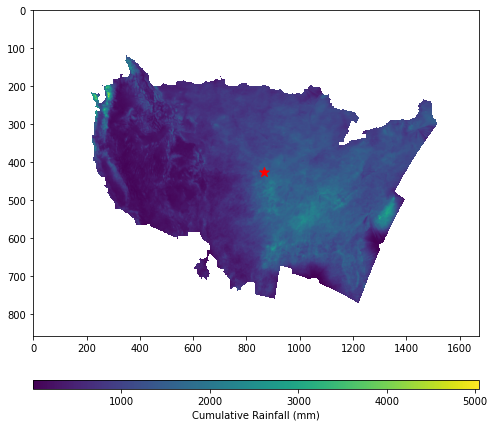

In [56]:
# Plot Map of cummulative rainfall

plt.figure(figsize=(8,8))
plt.imshow(cum_rainfall, aspect='auto')
plt.colorbar(orientation="horizontal", pad=0.1, aspect=50, label="Cumulative Rainfall (mm)")
plt.scatter(row_col[1],row_col[0], marker='*', color='r', s=100)
plt.gca().axes.get_xaxis().set_visible(True)
plt.gca().axes.get_yaxis().set_visible(True)
plt.show()
